In [ ]:
# Only run this cell on google colab
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Only run this cell on google colab
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/MyDrive/smart_ris_ver_3.0')

In [18]:
import numpy as np
from module import ml_model as ml
from module import system, riemannian, util
from typing import List
from time import time

In [2]:
config = util.load_config('../configs/config.yaml')

In [4]:
network = system.Network(config=config)

# Model 1
DNN_100 = ml.DNN(config=config)
DNN_100.load_model('../models/1_CH_100_phases_400000_samples')


In [8]:
# Generate one realization of CH
network.generate_one_CHs_realization(r_max=50.0)
# Assign coefficients
network.generate_and_assign_coefs(random_angles=False)

large_scale_coef = network.generate_parameters()

# Use optimal phase
phase = - np.angle(large_scale_coef.A).reshape(network.RIS.num_phase, 1)
network.RIS.phase = (2 * np.pi + phase) * (phase < 0) + phase * (phase > 0)
print('Optimal phase - continuous:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=3)
print('Optimal phase - Q=3:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=2)
print('Optimal phase - Q=2:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=1)
print('Optimal phase - Q=1:', network.calculate_ergodic_SE_using_vectorization())

# Use DNN phase
network.RIS.phase = DNN_100.predict(large_scale_coef)
print('DNN - continuous:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=3)
print('DNN - Q=3:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=2)
print('DNN - Q=2:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=1)
print('DNN - Q=1:', network.calculate_ergodic_SE_using_vectorization())

# Use random phase
network.RIS.get_random_phase()
print('Random - continuous:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=3)
print('Random - Q=3:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=2)
print('Random - Q=2:', network.calculate_ergodic_SE_using_vectorization())
network.RIS.get_quantized_phase(Q=1)
print('Random - Q=1:', network.calculate_ergodic_SE_using_vectorization())

Optimal phase - continuous: 3.4563120192716372
Optimal phase - Q=3: 3.436102301415411
Optimal phase - Q=2: 3.2383231875530534
Optimal phase - Q=1: 2.5873550998591015
DNN - continuous: 3.2663163291327315
DNN - Q=3: 3.0515623193879096
DNN - Q=2: 2.748365983827902
DNN - Q=1: 2.0631486335870255
Random - continuous: 1.6847341501292963
Random - Q=3: 1.7081861406585235
Random - Q=2: 1.7205075413379887
Random - Q=1: 1.648480742426017


In [9]:
def calculate(DNN: ml.DNN, network: system.Network) -> List:
    """
    Calculate the ergodic performance for:
    Optimal, DNN and random method

    Args:
        DNN (ml.DNN): [DNN model]
        network (system.Network): [A network object]

    Returns:
        List: [performance]
    """
    P_dbm = np.array([0., 10., 20., 30., 40.])
    P = 10 ** (P_dbm / 10) / 1000

    optimal_ergodic = 5 * [0.]
    DNN_ergodic = 5 * [0.]
    random_ergodic = 5 * [0.]

    # Generate one realization of CH
    network.generate_one_CHs_realization(r_max=20.0)
    # Assign coefficients
    network.generate_and_assign_coefs(random_angles=False)

    for i in range(len(P)):

        network.BS.power = P[i]
        large_scale_coef = network.generate_parameters()

        # Optimal phase
        phase = - np.angle(large_scale_coef.A).reshape(network.RIS.num_phase, 1)
        network.RIS.phase = (2 * np.pi + phase) * (phase < 0) + phase * (phase > 0)
        optimal_ergodic[i] = network.calculate_ergodic_SE_using_vectorization(n_loop=1000)

        # Generate phase using DNN
        network.RIS.phase = DNN.predict(large_scale_coef)
        DNN_ergodic[i] = network.calculate_ergodic_SE_using_vectorization(n_loop=1000)

        # Generate random phase
        network.RIS.get_random_phase()
        random_ergodic[i] = network.calculate_ergodic_SE_using_vectorization(n_loop=1000)
    
    return np.array(
        [optimal_ergodic, DNN_ergodic, random_ergodic]
    )

In [14]:
config["system_model"]["RIS"]["num_phase"] = 100
network = system.Network(config=config)

# DNN using 100 phases
DNN_100 = ml.DNN(config=config)
DNN_100.load_model('../models/1_CH_100_phases_400000_samples')

n_loop = 10
performance_100 = 0.

for i in range(n_loop):
    if i % 100 == 0:
        print(i)
    performance_100 += calculate(DNN_100, network)

performance_100 = performance_100 / n_loop

0


In [15]:
performance_100

array([[ 1.61774856,  3.03405036,  5.27276654,  8.15134828, 11.37925439],
       [ 1.59100977,  2.98717617,  5.22791594,  8.09322831, 11.29411698],
       [ 0.63495201,  1.48622982,  2.95040553,  5.19370092,  8.21631047]])

In [16]:
config["system_model"]["RIS"]["num_phase"] = 200
network = system.Network(config=config)


# DNN using 200 phases
DNN_200 = ml.DNN(config=config)
DNN_200.load_model('../models/1_CH_200_phases_400000_samples')

n_loop = 10
performance_200 = 0.

for i in range(n_loop):
    if i % 100 == 0:
        print(i)
    performance_200 += calculate(DNN_200, network)

performance_200 = performance_200 / n_loop

0


In [17]:
performance_200

array([[ 2.80534193,  4.31861564,  6.60400046,  9.53178949, 12.77103204],
       [ 2.71032045,  4.2036817 ,  6.45569953,  9.3654034 , 12.60851248],
       [ 1.55134758,  2.33039621,  3.83653841,  5.99239105,  8.90361612]])

In [19]:
import numpy as np

# This result was executed by running the above code on Google Colab
performance_100 = np.array(
    [
        [0.6276427 , 1.44493792, 2.93175551, 5.17026854, 8.00499739],
        [0.61433294, 1.41829359, 2.88678132, 5.10568985, 7.92297366],
        [0.25949403, 0.7006152 , 1.66089354, 3.33520391, 5.74201486]
    ]
)
# Performance for 1 user, 200 phases are used
performance_200 = np.array(
    [
        [1.08234773, 2.27945596, 4.23484163, 6.88575534, 9.97278097],
        [1.04308349, 2.20638818, 4.12166757, 6.73943626, 9.80971692],
        [0.35642016, 0.95486702, 2.1261436 , 4.04356565, 6.65705635]
    ]
)

In [25]:
performance_200[0] / performance_200[2]

array([3.0367186 , 2.38719729, 1.99179474, 1.70289194, 1.49807669])

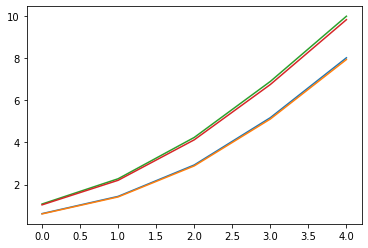

In [21]:
import matplotlib.pyplot as plt

plt.plot(performance_100[0])
plt.plot(performance_100[1])

plt.plot(performance_200[0])
plt.plot(performance_200[1])